<a href="https://colab.research.google.com/github/iremellz/MortgageDataModelling/blob/main/Mortgage-Default-Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from pandas.core.algorithms import mode
import random

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving column_names.csv to column_names.csv


In [ ]:
fileObject = open("column_names.csv", "r")
columns = fileObject.read()
column_names=columns.split('\n')
column_names[:-1]

['loan_id',
 'act_period',
 'channel',
 'orig_rate',
 'orig_upb',
 'orig_term',
 'orig_date',
 'first_pay',
 'loan_age',
 'rem_months',
 'matr_dt',
 'oltv',
 'ocltv',
 'num_bo',
 'dti',
 'cscore_b',
 'cscore_c',
 'first_flag',
 'purpose',
 'prop',
 'no_units',
 'occ_stat',
 'state',
 'msa',
 'zip',
 'mi_pct',
 'dlq_status',
 'zero_bal_code',
 'zb_dte',
 'mi_type',
 'homeready_program_indicator',
 'relocation_mortgage_indicator',
 'high_balance_loan_indicator',
 'target',
 'last_period',
 'calc_age',
 'age_dif',
 'calc_rem_months',
 'cscore_min',
 'orig_val',
 'Vintage',
 'Prepay',
 'Default']

# Identifying Dropping Columns that Contain Future Information

- *loan_age, mi_pct*  KEEP IT!!

- *'rem_months', 'matr_dt'* will also be dropped as they have future information: "The number of calendar months remaining until the mortgage loan is due to be paid in full based on the maturity date as defined in the mortgage documents." "The month and year in which a mortgage loan is scheduled to be paid in full as defined in the mortgage loan documents.

- zero_bal_cod and dlq_status dropped as it has information about the target column.

- 'act_period' or 'last_period' also contains future information and will be dropped from the dataset.

- 'calc_age', 'age_dif', 'calc_rem_months' will be dropped as well as these are calculated by using 'last_period'

-  "target" column was not present in the original data. It was available in the modified dataset that we created at the end of the project. The target column denotes termination states and has there values: 'active', 'default' and 'prepaid'



 # Uploading Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1XekjJ-nLbS7MAWCvKgorztClFGUv5dOJ'
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])


Mounted at /content/gdrive


In [ ]:
df= pd.read_csv('model_data.csv', sep= '|', header=None, names=column_names[:-1], low_memory=False)
df.head()

,loan_id,act_period,channel,orig_rate,orig_upb,orig_term,orig_date,first_pay,loan_age,rem_months,...,target,last_period,calc_age,age_dif,calc_rem_months,cscore_min,orig_val,Vintage,Prepay,Default
NaN,loan_id,act_period,channel,orig_rate,orig_upb,orig_term,orig_date,first_pay,loan_age,rem_months,...,target,last_period,calc_age,age_dif,calc_rem_months,cscore_min,orig_val,Vintage,Prepay,Default
0.0,523899932680,2010-04-20,C,4.75,239000.0,360.0,2009-01-20,2009-03-20,14.0,346.0,...,A,NaN,15,1.0,346,778.0,412068.9655172414,2009,0,0
1.0,239106981350,2009-06-20,C,5.25,80000.0,180.0,2002-10-20,2003-01-20,81.0,99.0,...,P,2009-06-20,81,NaN,99,776.0,129032.25806451614,2002,1,0
2.0,667907597231,2018-05-20,R,2.875,210000.0,180.0,2012-12-20,2013-02-20,64.0,116.0,...,A,NaN,65,1.0,116,707.0,344262.2950819672,2012,0,0
3.0,940076896427,2012-05-20,B,6.875,134000.0,360.0,2002-09-20,2002-11-20,116.0,244.0,...,P,2012-05-20,116,NaN,244,710.0,138144.32989690723,2002,1,0


In [ ]:
df.Default.value_counts()


0          399908
1          157732
Default         1
Name: Default, dtype: int64

In [ ]:
df.zip.value_counts()

945    5551
300    4737
750    4712
606    4603
600    4447
       ... 
865       1
849       1
348       1
964       1
886       1
Name: zip, Length: 913, dtype: int64

In [ ]:
df.zip

NaN         zip
0.0         801
1.0         986
2.0         117
3.0         701
           ... 
580101.0    351
580102.0    571
580103.0    190
580104.0    286
580105.0    190
Name: zip, Length: 557641, dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 557641 entries, nan to 580105.0
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   loan_id                        557641 non-null  object
 1   act_period                     557641 non-null  object
 2   channel                        557641 non-null  object
 3   orig_rate                      557641 non-null  object
 4   orig_upb                       557641 non-null  object
 5   orig_term                      557641 non-null  object
 6   orig_date                      557641 non-null  object
 7   first_pay                      557641 non-null  object
 8   loan_age                       557641 non-null  object
 9   rem_months                     557641 non-null  object
 10  matr_dt                        379232 non-null  object
 11  oltv                           557641 non-null  object
 12  ocltv                          557641 

In [ ]:
df['target'].value_counts()

A         228762
P         171146
D         157732
target         1
Name: target, dtype: int64

In [ ]:
df['Default'].value_counts()

0          399908
1          157732
Default         1
Name: Default, dtype: int64

In [ ]:
len(df)

557641

In [ ]:
df_def = df[df['Default']=='1']
df_ndef = df[df['Default']=='0']
len(df_def),len(df_ndef)

(157732, 399908)

In [ ]:
df_ndef = df_ndef.sample(frac=0.5, axis=0, random_state=0)
len(df_def),len(df_ndef)

(157732, 199954)

In [ ]:
df_bal = pd.concat([df_def,df_ndef],axis=0)
df_bal.Default.value_counts()

0    199954
1    157732
Name: Default, dtype: int64

In [ ]:
df_bal.reset_index(drop=True, inplace=True)
df_bal = df_bal.iloc[1: , :]


In [ ]:
df1= df_bal.drop(['dlq_status', 'rem_months', 'matr_dt','act_period', 'last_period', 'calc_age', 'age_dif', 'calc_rem_months', 'Default', 'Prepay'], axis=1)
df1.head()

,loan_id,channel,orig_rate,orig_upb,orig_term,orig_date,first_pay,loan_age,oltv,ocltv,...,zero_bal_code,zb_dte,mi_type,homeready_program_indicator,relocation_mortgage_indicator,high_balance_loan_indicator,target,cscore_min,orig_val,Vintage
1,676470473495,C,6.125,138000.0,360.0,2008-11-20,2009-01-20,113.0,80.0,80.0,...,NaN,NaN,NaN,NaN,N,N,D,591.0,172500.0,2008
2,454566884436,C,6.75,151000.0,360.0,2007-08-20,2007-10-20,62.0,90.0,90.0,...,NaN,NaN,2.0,NaN,N,N,D,723.0,167777.77777777778,2007
3,120142086453,C,4.125,304000.0,360.0,2013-07-20,2013-09-20,100.0,80.0,80.0,...,NaN,NaN,NaN,NaN,N,N,D,733.0,380000.0,2013
4,409620791247,C,5.625,103000.0,360.0,2005-07-20,2005-09-20,71.0,93.0,93.0,...,NaN,NaN,1.0,NaN,N,N,D,684.0,110752.68817204301,2005
5,736342864722,R,6.5,36000.0,360.0,2003-03-20,2003-05-20,74.0,87.0,87.0,...,NaN,NaN,1.0,NaN,N,N,D,656.0,41379.31034482759,2003


In [ ]:
df1.describe()

,loan_id,channel,orig_rate,orig_upb,orig_term,orig_date,first_pay,loan_age,oltv,ocltv,...,zero_bal_code,zb_dte,mi_type,homeready_program_indicator,relocation_mortgage_indicator,high_balance_loan_indicator,target,cscore_min,orig_val,Vintage
count,357685,357685,357685,357685,357685,357685,357685,357685,357685,357685,...,92685,92685,83701,46037,357685,357685,357685,357685,357685,357685
unique,356740,3,1392,544,166,276,276,185,95,95,...,7,260,3,2,2,2,3,391,20031,23
top,507651629425,R,5.875,417000.0,360.0,2003-04-20,2003-06-20,14.0,80.0,80.0,...,01,2003-07-20,1.0,N,N,N,D,814.0,983720.9302325582,2007
freq,3,165973,22488,4950,276498,5428,5375,4883,75806,67911,...,85579,1150,77186,42569,356284,353956,157731,3281,3085,30519


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357685 entries, 1 to 357685
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   loan_id                        357685 non-null  object
 1   channel                        357685 non-null  object
 2   orig_rate                      357685 non-null  object
 3   orig_upb                       357685 non-null  object
 4   orig_term                      357685 non-null  object
 5   orig_date                      357685 non-null  object
 6   first_pay                      357685 non-null  object
 7   loan_age                       357685 non-null  object
 8   oltv                           357685 non-null  object
 9   ocltv                          357685 non-null  object
 10  num_bo                         357619 non-null  object
 11  dti                            357685 non-null  object
 12  cscore_b                       357685 non-nu

In [ ]:
print(df1.isnull().sum()*100/len(df1))

loan_id                           0.000000
channel                           0.000000
orig_rate                         0.000000
orig_upb                          0.000000
orig_term                         0.000000
orig_date                         0.000000
first_pay                         0.000000
loan_age                          0.000000
oltv                              0.000000
ocltv                             0.000000
num_bo                            0.018452
dti                               0.000000
cscore_b                          0.000000
cscore_c                          0.000000
first_flag                        0.054238
purpose                           0.000000
prop                              0.000000
no_units                          0.000000
occ_stat                          0.000000
state                             0.000000
msa                               0.000000
zip                               0.000280
mi_pct                            0.000000
zero_bal_co

In [ ]:
df2= df1.drop(['zero_bal_code','zb_dte','zip'], axis=1)
df2.head()

,loan_id,channel,orig_rate,orig_upb,orig_term,orig_date,first_pay,loan_age,oltv,ocltv,...,msa,mi_pct,mi_type,homeready_program_indicator,relocation_mortgage_indicator,high_balance_loan_indicator,target,cscore_min,orig_val,Vintage
1,676470473495,C,6.125,138000.0,360.0,2008-11-20,2009-01-20,113.0,80.0,80.0,...,26420,25.0,NaN,NaN,N,N,D,591.0,172500.0,2008
2,454566884436,C,6.75,151000.0,360.0,2007-08-20,2007-10-20,62.0,90.0,90.0,...,36740,25.0,2.0,NaN,N,N,D,723.0,167777.77777777778,2007
3,120142086453,C,4.125,304000.0,360.0,2013-07-20,2013-09-20,100.0,80.0,80.0,...,35620,25.0,NaN,NaN,N,N,D,733.0,380000.0,2013
4,409620791247,C,5.625,103000.0,360.0,2005-07-20,2005-09-20,71.0,93.0,93.0,...,21780,30.0,1.0,NaN,N,N,D,684.0,110752.68817204301,2005
5,736342864722,R,6.5,36000.0,360.0,2003-03-20,2003-05-20,74.0,87.0,87.0,...,33340,25.0,1.0,NaN,N,N,D,656.0,41379.31034482759,2003


# Imputing Missing Values

In [ ]:
df2['homeready_program_indicator'].unique()

array([nan, 'N', 'Y'], dtype=object)

In [ ]:
df2['homeready_program_indicator'].value_counts()

N    42569
Y     3468
Name: homeready_program_indicator, dtype: int64

In [ ]:
df2['homeready_program_indicator'].fillna(df2['homeready_program_indicator'].mode()[0], inplace=True)

In [ ]:
df2['homeready_program_indicator'].value_counts()

N    354217
Y      3468
Name: homeready_program_indicator, dtype: int64

In [ ]:
df2['homeready_program_indicator'].unique()

array(['N', 'Y'], dtype=object)

In [ ]:
df2['mi_type'].value_counts()

1.0    77186
2.0     6473
3.0       42
Name: mi_type, dtype: int64

In [ ]:
df2['mi_type'].unique()

array([nan, '2.0', '1.0', '3.0'], dtype=object)

In [ ]:
from locale import normalize
df2['mi_type'].value_counts(normalize=True)

1.0    0.922163
2.0    0.077335
3.0    0.000502
Name: mi_type, dtype: float64

In [ ]:
df2['mi_type'] = df2['mi_type'].fillna(0) #imputed with 0 means no mortgage insurance for those

In [ ]:
df2['mi_type'].value_counts()

0      273984
1.0     77186
2.0      6473
3.0        42
Name: mi_type, dtype: int64

In [ ]:
df2['first_flag'].fillna(df2['first_flag'].mode()[0], inplace = True)
df2['num_bo'].fillna(df2['num_bo'].mode()[0], inplace = True)

In [ ]:
print(df2.isnull().sum()*100/len(df2))

loan_id                          0.0
channel                          0.0
orig_rate                        0.0
orig_upb                         0.0
orig_term                        0.0
orig_date                        0.0
first_pay                        0.0
loan_age                         0.0
oltv                             0.0
ocltv                            0.0
num_bo                           0.0
dti                              0.0
cscore_b                         0.0
cscore_c                         0.0
first_flag                       0.0
purpose                          0.0
prop                             0.0
no_units                         0.0
occ_stat                         0.0
state                            0.0
msa                              0.0
mi_pct                           0.0
mi_type                          0.0
homeready_program_indicator      0.0
relocation_mortgage_indicator    0.0
high_balance_loan_indicator      0.0
target                           0.0
c

In [ ]:
df3=df2

In [ ]:
(df3['ocltv']== df3['oltv']).value_counts()

True     333675
False     24010
dtype: int64

In [ ]:
df3['num_bo'].value_counts()

1.0    182895
2.0    173021
3.0      1401
4.0       362
6.0         3
5.0         2
7.0         1
Name: num_bo, dtype: int64

# Setting the Target Values

In [ ]:
df3['Target']= df3.apply(lambda x : 1 if x['target']=='D' else 0,axis=1)

In [ ]:
df3['Target'].value_counts()

0    199954
1    157731
Name: Target, dtype: int64

In [ ]:
df3.drop(columns=['target'], inplace=True)

## Seperation of the Categorical and Numerical Features and changing the Data Types

In [ ]:
cat_cols = ['channel', 'num_bo','first_flag','purpose','prop','no_units', 'occ_stat','state',
'msa','mi_type','homeready_program_indicator','relocation_mortgage_indicator','high_balance_loan_indicator','Vintage']


In [ ]:
num_cols = ['loan_age', 'mi_pct','orig_rate','orig_upb','orig_term','oltv','ocltv','dti','cscore_b','cscore_c','cscore_min','orig_val','Target',]


In [ ]:
df3['mi_pct']

1         25.0
2         25.0
3         25.0
4         30.0
5         25.0
          ... 
357681    25.0
357682    25.0
357683    25.0
357684    25.0
357685    25.0
Name: mi_pct, Length: 357685, dtype: object

In [ ]:
df4 = df3.copy()
for col in num_cols:
  df4[col] = df4[col].astype("float64")


In [ ]:

  df4['Target'] = df4['Target'].astype("int")
  df4['loan_id'] = df4['loan_id'].astype("int")

In [ ]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357685 entries, 1 to 357685
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_id                        357685 non-null  int64  
 1   channel                        357685 non-null  object 
 2   orig_rate                      357685 non-null  float64
 3   orig_upb                       357685 non-null  float64
 4   orig_term                      357685 non-null  float64
 5   orig_date                      357685 non-null  object 
 6   first_pay                      357685 non-null  object 
 7   loan_age                       357685 non-null  float64
 8   oltv                           357685 non-null  float64
 9   ocltv                          357685 non-null  float64
 10  num_bo                         357685 non-null  object 
 11  dti                            357685 non-null  float64
 12  cscore_b                      

**Skewness Test**

Skewness of loan_age is 0.958654751341923


<Figure size 576x396 with 0 Axes>

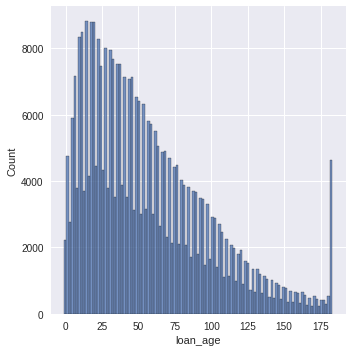

Skewness of mi_pct is -2.2670478223311523


<Figure size 576x396 with 0 Axes>

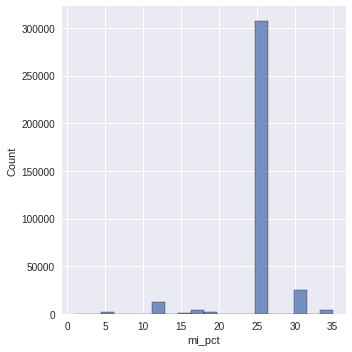

Skewness of orig_rate is -0.17237561723858857


<Figure size 576x396 with 0 Axes>

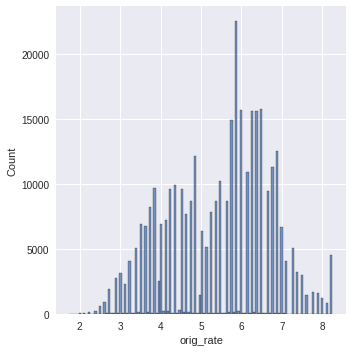

Skewness of orig_upb is 0.9489473557333374


<Figure size 576x396 with 0 Axes>

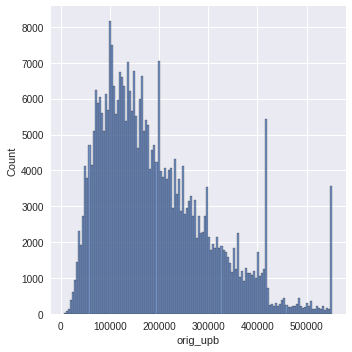

Skewness of orig_term is -1.4987113769980562


<Figure size 576x396 with 0 Axes>

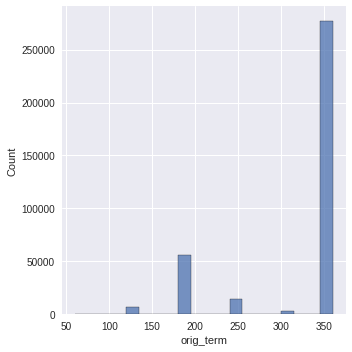

Skewness of oltv is -0.9637125026892466


<Figure size 576x396 with 0 Axes>

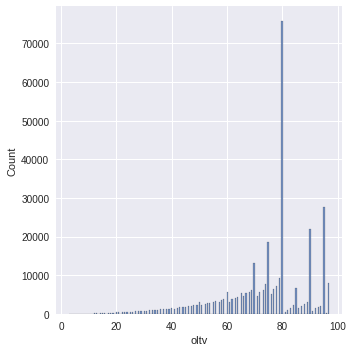

Skewness of ocltv is -0.9704723176228653


<Figure size 576x396 with 0 Axes>

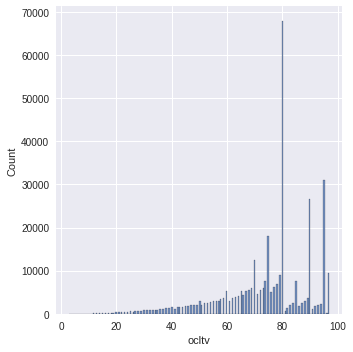

Skewness of dti is -0.08124708097291189


<Figure size 576x396 with 0 Axes>

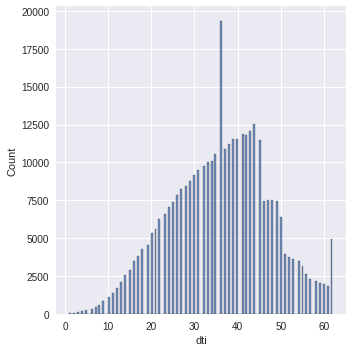

Skewness of cscore_b is -0.448235752446656


<Figure size 576x396 with 0 Axes>

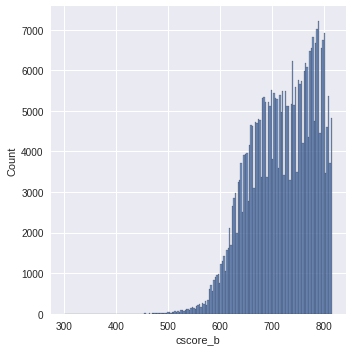

Skewness of cscore_c is -0.4663313148583972


<Figure size 576x396 with 0 Axes>

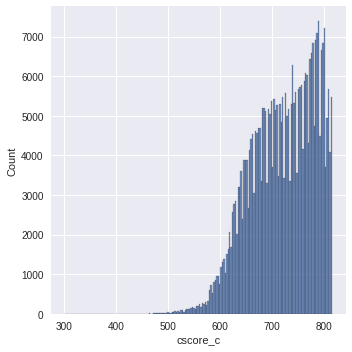

Skewness of cscore_min is -0.40423250284347195


<Figure size 576x396 with 0 Axes>

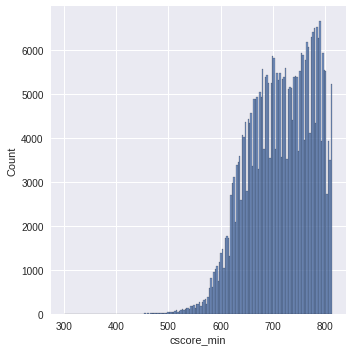

Skewness of orig_val is 1.472881858166969


<Figure size 576x396 with 0 Axes>

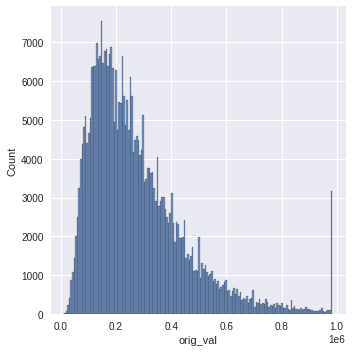

Skewness of Target is 0.23775272904405842


<Figure size 576x396 with 0 Axes>

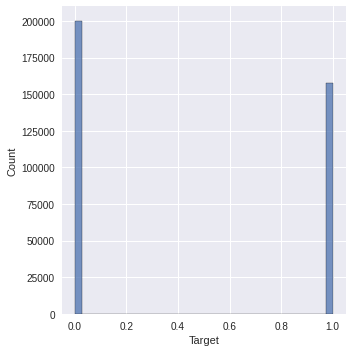

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox, skew, kurtosis
for col in num_cols:

    print(f'Skewness of {col} is {skew(df4[col])}')

    plt.figure()
    sns.displot(df4[col])
    plt.show()


'orig_value' is right skewed. So we can use log or sqrt transformation for this feature. The rest are acceptable.

*   For those skeweness values(absolute values) between 0.5 to 1, shall we also do some kind of transformation?    



channel


<Figure size 864x864 with 0 Axes>

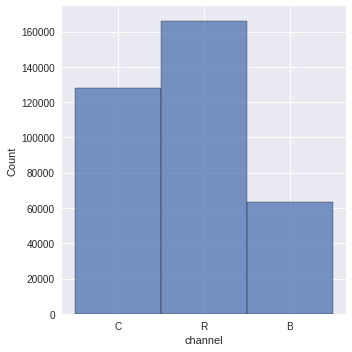

num_bo


<Figure size 864x864 with 0 Axes>

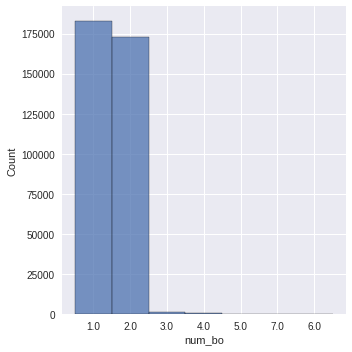

first_flag


<Figure size 864x864 with 0 Axes>

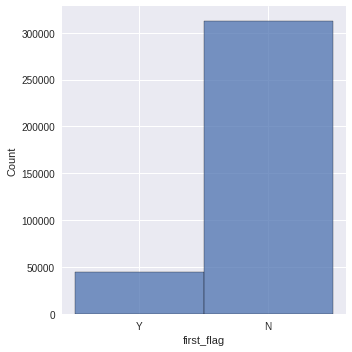

purpose


<Figure size 864x864 with 0 Axes>

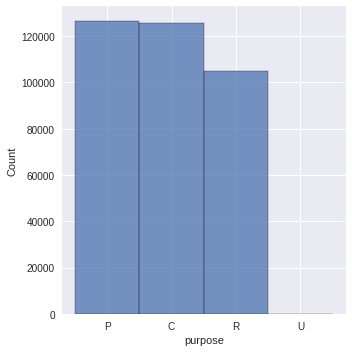

prop


<Figure size 864x864 with 0 Axes>

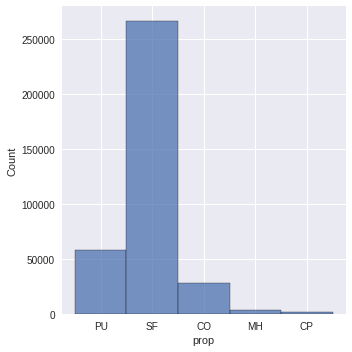

no_units


<Figure size 864x864 with 0 Axes>

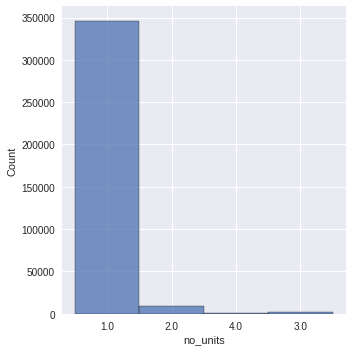

occ_stat


<Figure size 864x864 with 0 Axes>

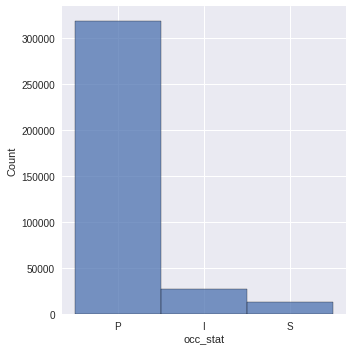

state


<Figure size 864x864 with 0 Axes>

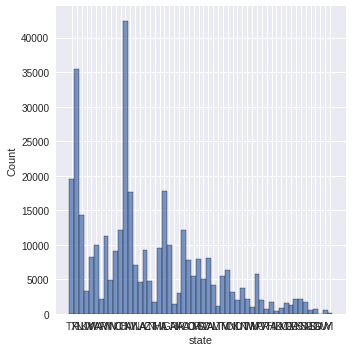

msa


<Figure size 864x864 with 0 Axes>

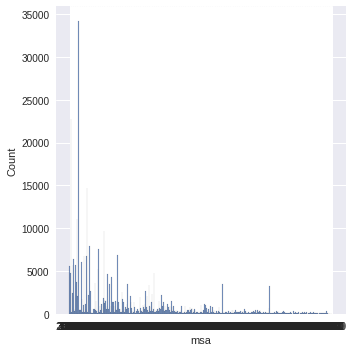

mi_type


<Figure size 864x864 with 0 Axes>

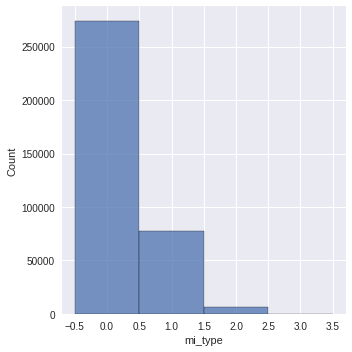

homeready_program_indicator


<Figure size 864x864 with 0 Axes>

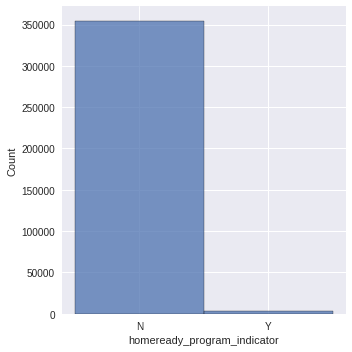

relocation_mortgage_indicator


<Figure size 864x864 with 0 Axes>

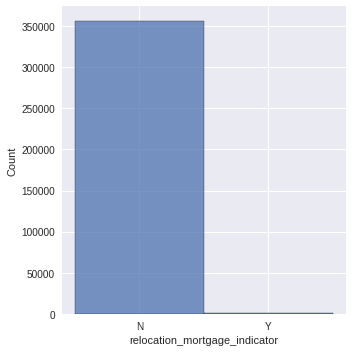

high_balance_loan_indicator


<Figure size 864x864 with 0 Axes>

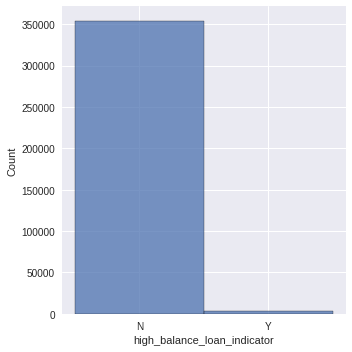

Vintage


<Figure size 864x864 with 0 Axes>

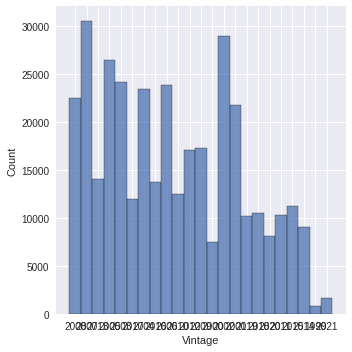

In [ ]:
for col in cat_cols:
    print(col)

    plt.figure(figsize=(12,12))
    sns.displot(df4[col])
    plt.show()

**Using sqrt transformation to eliminate skewness of orig_val**

In [ ]:
import math
df4['orig_val']= np.sqrt(df4['orig_val'])


In [ ]:
skew(df4['orig_val'])

0.6427860625999857

# **Correlation Matrix**

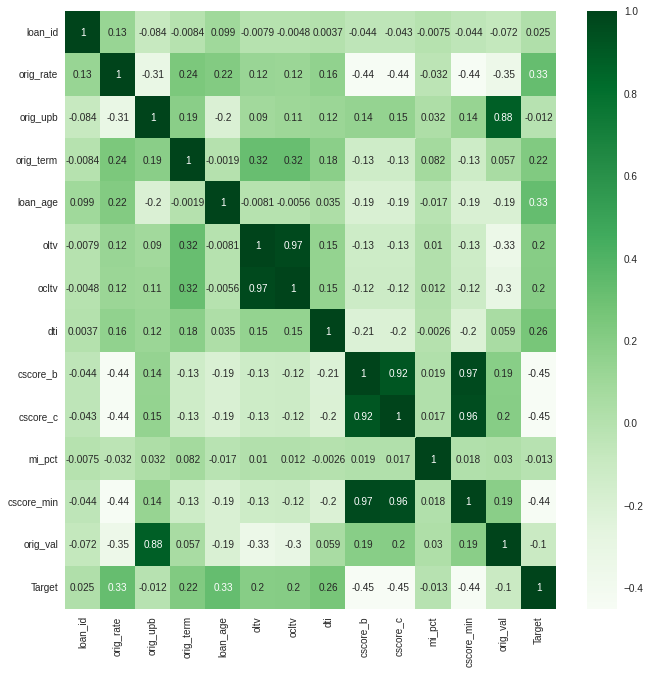

In [ ]:
plt.figure(figsize=(11,11))
sns.heatmap(df4.corr(),cmap="Greens", annot=True);

According to the correlation table, 'oltv' and 'ocltv' are highly correlated. One of these two features can be dropped. Both 'cscore_b' and 'cscore_c' are correlated with 'cscore_min'. We can keep 'csore_min' and drop both 'cscore_b' and 'cscore_c'. 'orig_ubp' has a very small correlation with Target, this feature can also be dropped.


## Dropping the correlated features

In [ ]:
df5 = df4.drop(['orig_val','cscore_b','cscore_c','msa'], axis=1)
df5.head()

,loan_id,channel,orig_rate,orig_upb,orig_term,orig_date,first_pay,loan_age,oltv,ocltv,...,occ_stat,state,mi_pct,mi_type,homeready_program_indicator,relocation_mortgage_indicator,high_balance_loan_indicator,cscore_min,Vintage,Target
1,676470473495,C,6.125,138000.0,360.0,2008-11-20,2009-01-20,113.0,80.0,80.0,...,P,TX,25.0,0,N,N,N,591.0,2008,1
2,454566884436,C,6.750,151000.0,360.0,2007-08-20,2007-10-20,62.0,90.0,90.0,...,P,FL,25.0,2.0,N,N,N,723.0,2007,1
3,120142086453,C,4.125,304000.0,360.0,2013-07-20,2013-09-20,100.0,80.0,80.0,...,P,NJ,25.0,0,N,N,N,733.0,2013,1
4,409620791247,C,5.625,103000.0,360.0,2005-07-20,2005-09-20,71.0,93.0,93.0,...,P,KY,30.0,1.0,N,N,N,684.0,2005,1
5,736342864722,R,6.500,36000.0,360.0,2003-03-20,2003-05-20,74.0,87.0,87.0,...,P,WI,25.0,1.0,N,N,N,656.0,2003,1


In [ ]:
df5 = df4.drop(['ocltv'], axis=1)

# Checking Outliers

<Figure size 5040x5040 with 0 Axes>

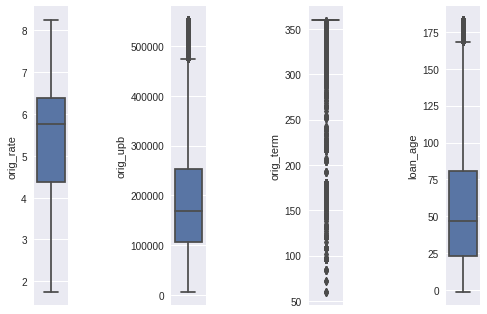

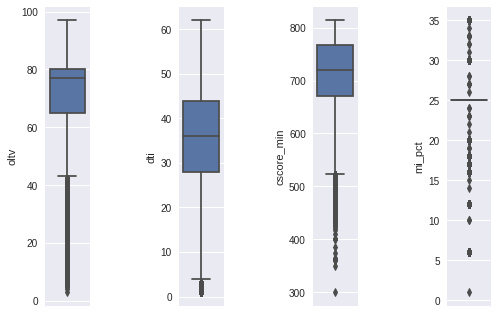

In [ ]:
plt.figure(figsize=(70,70))

num_cols1 = ['orig_rate', 'orig_upb', 'orig_term', 'loan_age']
fig, axes = plt.subplots(1, len(num_cols1))
for i, col in enumerate(num_cols1):
    ax = sns.boxplot(y=df5[col], ax=axes.flatten()[i])

plt.subplots_adjust(wspace=3);

num_cols2 = ['oltv', 'dti', 'cscore_min', 'mi_pct']
fig, axes = plt.subplots(1, len(num_cols2))
for i, col in enumerate(num_cols2):
    ax = sns.boxplot(y=df5[col], ax=axes.flatten()[i])

plt.subplots_adjust(wspace=2);
plt.show();

In [ ]:
df5.shape

(357685, 29)

In [ ]:
def cap_floor(df5, x_val):
  q_l = df5[x_val].quantile(0.01)
  q_h = df5[x_val].quantile(0.99)

  df5.loc[df5[x_val]<= q_l, x_val] = q_l
  df5.loc[df5[x_val]>= q_h, x_val] = q_h

In [ ]:
df5.shape

(357685, 29)

In [ ]:
cat_cols3 = ['channel', 'num_bo','first_flag','purpose','prop','no_units', 'occ_stat','state','mi_type','homeready_program_indicator','relocation_mortgage_indicator','high_balance_loan_indicator','Vintage']

num_cols3 = ['loan_age', 'mi_pct', 'orig_rate','orig_upb','orig_term','oltv','dti','cscore_min']    #New num_cols after dropped ones

In [ ]:
for i in (num_cols3):

  cap_floor(df5, i)

In [ ]:
df5.shape

(357685, 29)

We can check the skewness one more time at that stage and do the sutiable transformation

In [ ]:
df4.describe()

,loan_id,orig_rate,orig_upb,orig_term,loan_age,oltv,ocltv,dti,cscore_b,cscore_c,mi_pct,cscore_min,orig_val,Target
count,3.576850e+05,357685.000000,357685.000000,357685.000000,357685.000000,357685.000000,357685.000000,357685.000000,357685.000000,357685.000000,357685.000000,357685.000000,357685.000000,357685.000000
mean,5.240415e+11,5.442976,191666.701148,321.749405,56.555327,73.066768,73.921448,36.120919,720.072335,721.260008,24.755503,715.239490,501.571857,0.440977
std,2.789330e+11,1.258122,109961.957098,73.194333,41.936153,16.365502,16.457186,11.569231,61.264515,61.446928,3.416787,61.330461,156.223416,0.496505
min,9.747306e+07,1.750000,7000.000000,60.000000,-1.000000,3.000000,3.000000,1.000000,300.000000,300.000000,1.000000,300.000000,107.605517,0.000000
25%,2.916446e+11,4.375000,107000.000000,360.000000,23.000000,65.000000,66.000000,28.000000,675.000000,676.000000,25.000000,670.000000,386.618267,0.000000
50%,5.280973e+11,5.750000,168000.000000,360.000000,47.000000,77.000000,78.000000,36.000000,726.000000,727.000000,25.000000,720.000000,483.953021,0.000000
75%,7.636238e+11,6.375000,254000.000000,360.000000,81.000000,80.000000,85.000000,44.000000,773.000000,774.000000,25.000000,768.000000,596.657356,1.000000
max,9.999940e+11,8.250000,552000.000000,360.000000,183.000000,97.000000,97.000000,62.000000,816.000000,816.000000,35.000000,814.000000,991.827067,1.000000


## Analyzing Skewness after Removing Outliers

In [ ]:
for i in num_cols3:
  print(i,skew(df5[i]))

loan_age 0.15214600062576983
mi_pct -1.981577899711971
orig_rate -0.15878526733981804
orig_upb 0.3536531138388629
orig_term -1.3592792529132636
oltv 0.5400345002349367
dti -0.05012485435373914
cscore_min -0.3134373266416412


In [ ]:
# Data smoothing through square root function on the orig_upb feature to eliminate skewness.
df5['orig_upb']= np.sqrt(df5['orig_upb'])

In [ ]:
df5['loan_age']= np.sqrt(df5['loan_age'])

In [ ]:
for i in ['orig_term', 'oltv']:
  df5[i] = np.square(df5[i])

In [ ]:
df5['mi_pct']= np.square(df5['mi_pct'])

In [ ]:
df5['orig_term'] = np.power(df5['orig_term'],4)

In [ ]:
for i in num_cols3:
  print(i,skew(df5[i]))

loan_age -0.38232566594022105
mi_pct -0.4288424702439922
orig_rate -0.15878526733981804
orig_upb 0.04538136031507089
orig_term -1.3090982103500122
oltv 1.4569759826038036
dti -0.05012485435373914
cscore_min -0.3134373266416412


In [ ]:
num_cols3

['loan_age',
 'mi_pct',
 'orig_rate',
 'orig_upb',
 'orig_term',
 'oltv',
 'dti',
 'cscore_min']

Skewness of loan_age is -0.38232566594022105


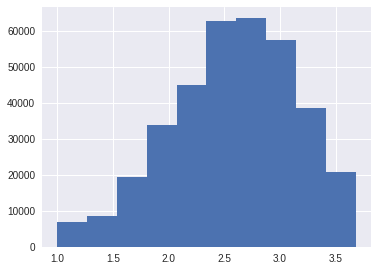

Skewness of mi_pct is -0.4288424702439922


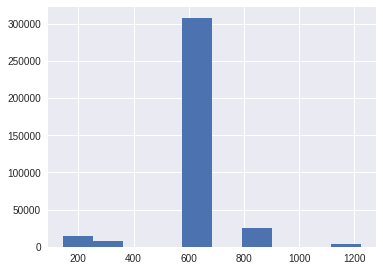

Skewness of orig_rate is -0.15878526733981804


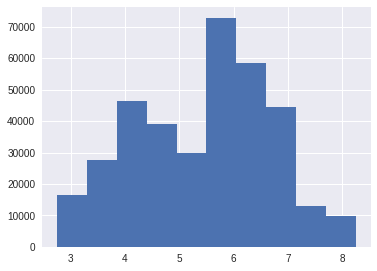

Skewness of orig_upb is 0.04538136031507089


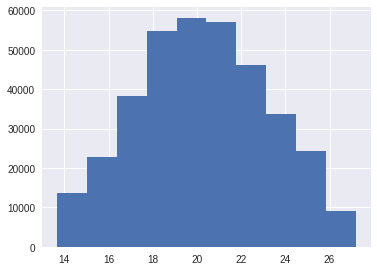

Skewness of orig_term is -1.3090982103500122


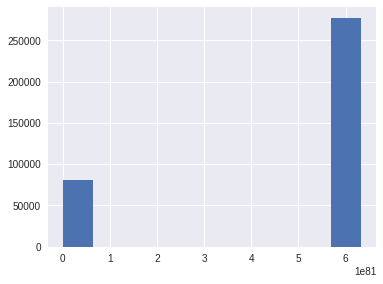

Skewness of oltv is 1.4569759826038036


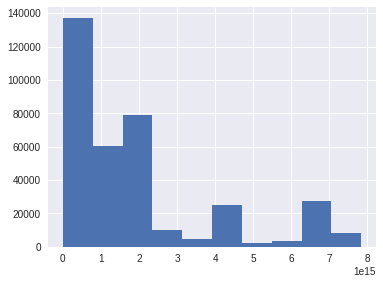

Skewness of dti is -0.05012485435373914


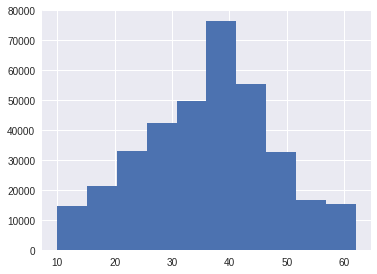

Skewness of cscore_min is -0.3134373266416412


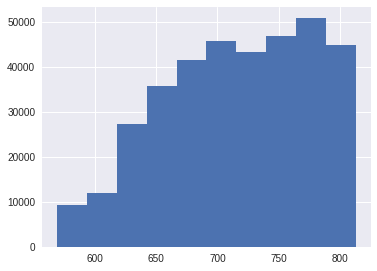

In [ ]:
for col in num_cols3:
  a=1
  plt.figure(figsize=(20,15))
  plt.subplot(3,3,a)
  print(f'Skewness of {col} is {skew(df5[col])}')
  plt.hist(df5[col])

#    g = sns.FacetGrid(df5[], row=a, col=b, margin_titles=False)
#    g.map(sns.displot, 'col', color=".3", fit_reg=False, x_jitter=.1)
  a+=1
  plt.show();


create and split test/train based on Vintage! slice the data in index 2014+vintage.

# **Graphs**

In [ ]:
def univariate_plot_v3(df5, x_var, y_var, bin_size):
  if x_var in num_cols3:
    fig,ax = plt.subplots()
    s=df5.groupby([pd.cut(df5[x_var], bins=bin_size, precision =0)]).agg({'loan_id':'count', y_var:'mean'})
    sns.barplot(x=x_var, y='loan_id', data=s.reset_index(), palette="Blues_d", ax=ax)
    ax2 = ax.twinx()
    sns.lineplot(x=range(len(s.reset_index())), y=y_var, data=s.reset_index(), color='red', markers=True, ax=ax2)
    ax.set_xticklabels(s.index.values, rotation = 45, ha="right")

  elif x_var in cat_cols3:
    fig,ax = plt.subplots()
    s=df5.groupby(df5[x_var]).agg({'loan_id':'count', y_var:'mean'})
    sns.barplot(x=x_var, y='loan_id', data=s.reset_index(), palette="Blues_d", ax=ax)
    ax2 = ax.twinx()
    sns.lineplot(x=range(len(s.reset_index())), y=y_var, data=s.reset_index(), color='red', markers=True, ax=ax2)
    ax.set_xticklabels(s.index.values, rotation = 45, ha="right")

<ipython-input-79-b8b72a3b1d15>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()
<ipython-input-79-b8b72a3b1d15>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()


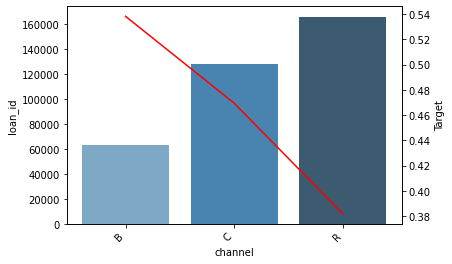

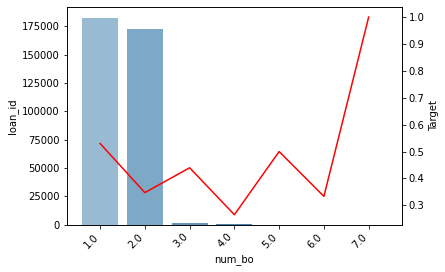

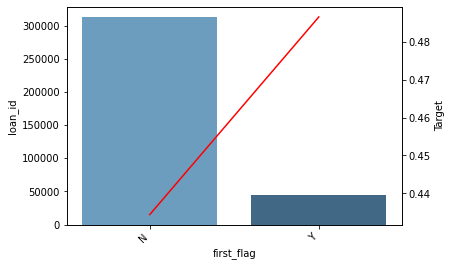

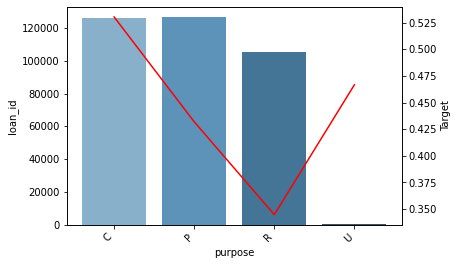

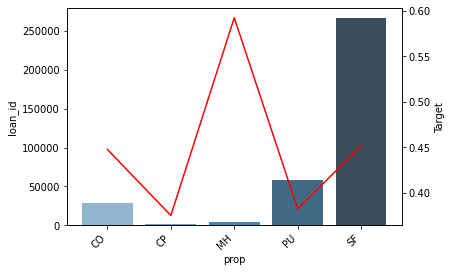

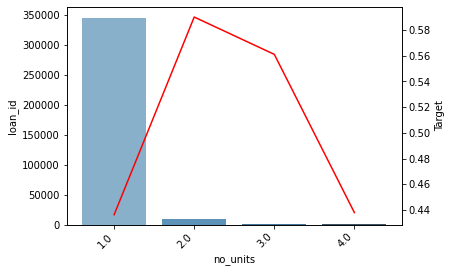

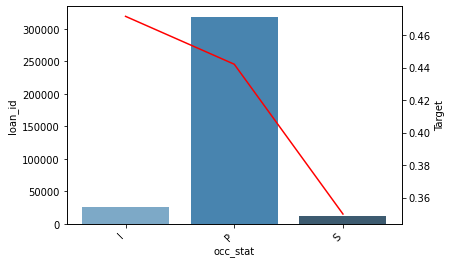

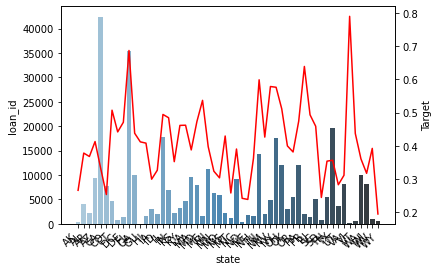

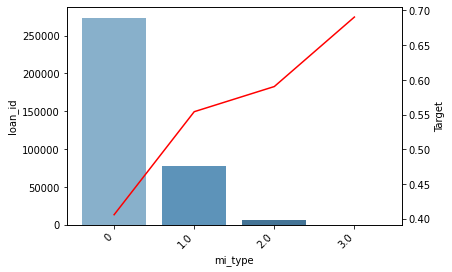

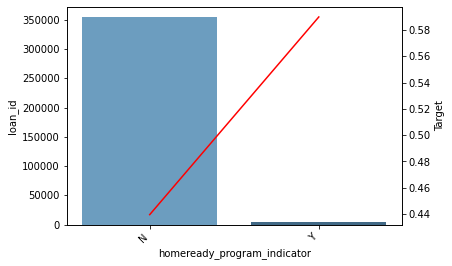

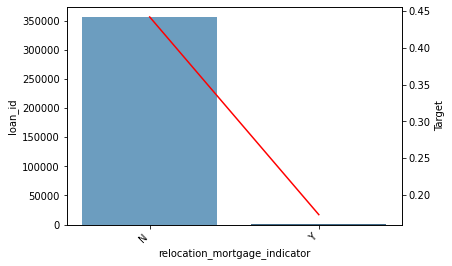

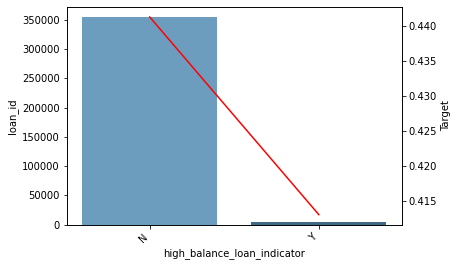

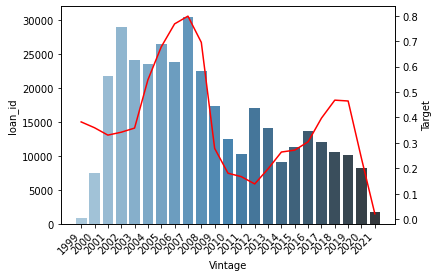

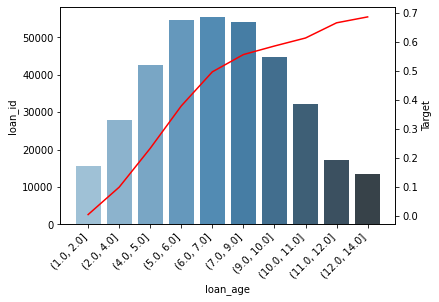

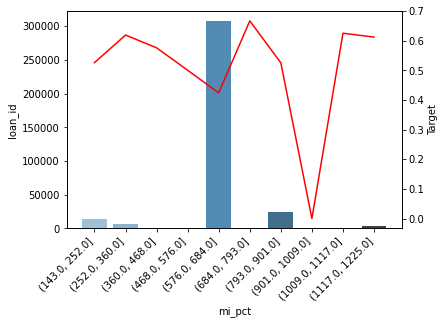

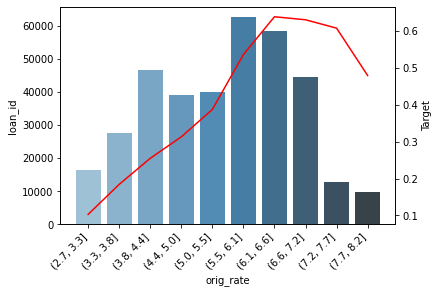

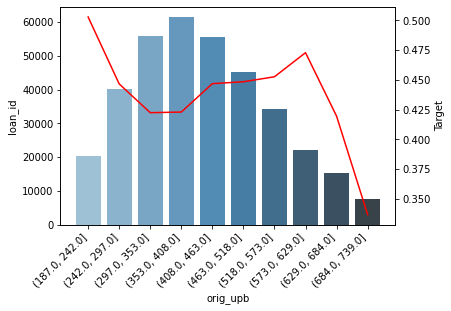

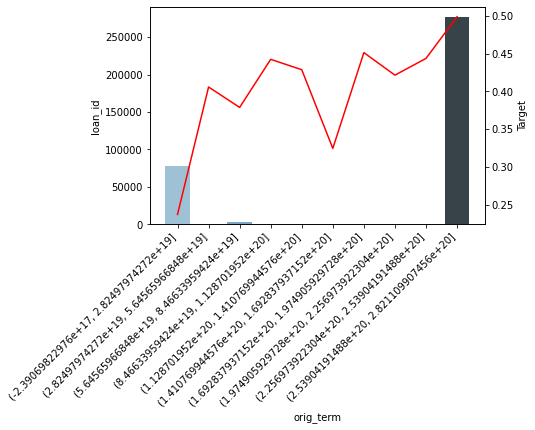

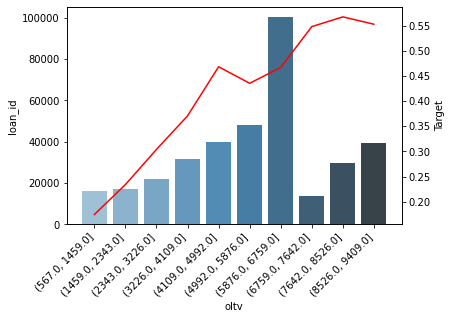

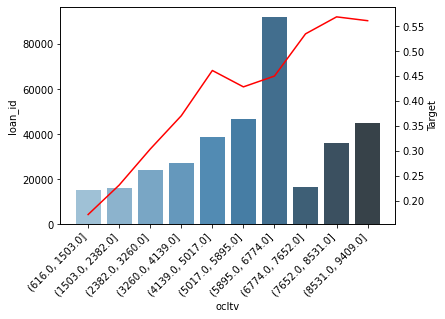

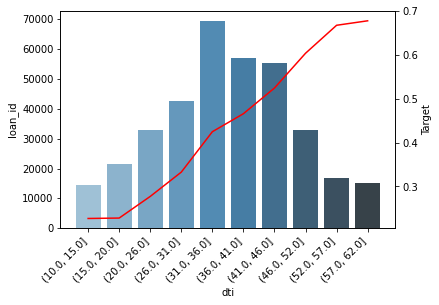

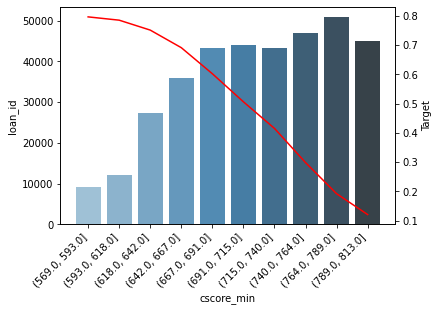

In [ ]:
vars_to_plot = cat_cols3 + num_cols3

for i in (vars_to_plot):
  univariate_plot_v3(df5,i,'Target', 10)

In [ ]:
df5 = df5.drop(columns=['loan_id'])

In [ ]:
# df5.head()

In [ ]:
df5.shape

(357685, 23)

### Setting the Data Types

In [ ]:
df5 = df5.copy()
for col in cat_cols3:
  df5[col] = df5[col].astype("str")

In [ ]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357685 entries, 1 to 357685
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_id                        357685 non-null  int64  
 1   channel                        357685 non-null  object 
 2   orig_rate                      357685 non-null  float64
 3   orig_upb                       357685 non-null  float64
 4   orig_term                      357685 non-null  float64
 5   orig_date                      357685 non-null  object 
 6   first_pay                      357685 non-null  object 
 7   loan_age                       357685 non-null  float64
 8   oltv                           357685 non-null  float64
 9   num_bo                         357685 non-null  object 
 10  dti                            357685 non-null  float64
 11  cscore_b                       357685 non-null  float64
 12  cscore_c                      

In [ ]:
df5=df5.drop(columns=['cscore_c','cscore_b','msa'],axis=1)

#**Applying the Machine Learning Models**


In [ ]:
X = df5.drop(columns=['Target'])
y = df5['Target']

## Splitting Data Using Vintage
The data is splitted into training and test set in terms of the Vintage. If the Vintage is more then 2014 then the data data is included in training set otherwise in test set.



In [ ]:
df5.head()

,loan_id,channel,orig_rate,orig_upb,orig_term,loan_age,oltv,ocltv,num_bo,dti,...,occ_stat,state,mi_pct,mi_type,homeready_program_indicator,relocation_mortgage_indicator,high_balance_loan_indicator,cscore_min,Vintage,Target
1,676470473495,C,6.125,371.483512,2.821110e+20,10.630146,6400.0,6400.0,1.0,46.0,...,P,TX,625.0,0,N,N,N,591.0,2008,1
2,454566884436,C,6.750,388.587185,2.821110e+20,7.874008,8100.0,8100.0,2.0,39.0,...,P,FL,625.0,2.0,N,N,N,723.0,2007,1
3,120142086453,C,4.125,551.361950,2.821110e+20,10.000000,6400.0,6400.0,2.0,49.0,...,P,NJ,625.0,0,N,N,N,733.0,2013,1
4,409620791247,C,5.625,320.936131,2.821110e+20,8.426150,8649.0,8649.0,1.0,58.0,...,P,KY,900.0,1.0,N,N,N,684.0,2005,1
5,736342864722,R,6.500,189.736660,2.821110e+20,8.602325,7569.0,7569.0,1.0,22.0,...,P,WI,625.0,1.0,N,N,N,656.0,2003,1


In [ ]:
(df5['Vintage']>= '2014').value_counts()

False    281124
True      76561
Name: Vintage, dtype: int64

## Downsampling the Data and Preparing the Data for Model Training/Testing

In [ ]:
df5_sample= df5.sample(frac=0.8, axis=0, random_state=0)

In [ ]:
df6 = df5_sample.loc[df5['Vintage'] < '2014']

In [ ]:
df7 = df5_sample.loc[df5['Vintage']>= '2014']

In [ ]:
df6.shape, df7.shape

((224913, 26), (61235, 26))

In [ ]:
X_train = df6.drop(columns = ['Target', 'Vintage'])

In [ ]:
y_train = df6['Target']

In [ ]:
X_test = df7.drop(columns = ['Target', 'Vintage'])

In [ ]:
y_test = df7['Target']

In [ ]:
X_train.shape, y_train.shape,X_test.shape, y_test.shape


((224913, 24), (224913,), (61235, 24), (61235,))

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224913 entries, 198051 to 209975
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_id                        224913 non-null  int64  
 1   channel                        224913 non-null  object 
 2   orig_rate                      224913 non-null  float64
 3   orig_upb                       224913 non-null  float64
 4   orig_term                      224913 non-null  float64
 5   orig_date                      224913 non-null  object 
 6   first_pay                      224913 non-null  object 
 7   loan_age                       224913 non-null  float64
 8   oltv                           224913 non-null  float64
 9   num_bo                         224913 non-null  object 
 10  dti                            224913 non-null  float64
 11  first_flag                     224913 non-null  object 
 12  purpose                  

In [ ]:
print('Test Data Percentage:',(len(X_test)/(len(X_train)+len(X_test)))*100)

Test Data Percentage: 21.399765156492446


In [ ]:
X_train.head(2)

,loan_id,channel,orig_rate,orig_upb,orig_term,orig_date,first_pay,loan_age,oltv,num_bo,...,no_units,occ_stat,state,mi_pct,mi_type,homeready_program_indicator,relocation_mortgage_indicator,high_balance_loan_indicator,cscore_min,orig_val
198051,864435226013,R,4.750,22.559265,6.334029e+81,2010-02-20,2010-04-20,2.378414,6.457535e+14,2.0,...,1.0,P,WA,625.0,0,N,N,N,788.0,603.977427
291089,692686989587,R,3.625,25.242450,6.334029e+81,2012-11-20,2013-01-20,2.806066,4.304672e+15,2.0,...,1.0,P,MD,625.0,1.0,N,N,N,778.0,671.648056


## Using the Column Transformer and Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [ ]:
cat_cols3 = ['channel','num_bo','first_flag','purpose','prop','no_units', 'occ_stat','state','mi_type','homeready_program_indicator','relocation_mortgage_indicator','high_balance_loan_indicator']

num_cols3 = ['loan_age', 'mi_pct', 'orig_rate','orig_upb','orig_term','oltv','dti','cscore_min']    #New num_cols after dropped ones

In [ ]:
transformer = ColumnTransformer(transformers=[
    ('ct', OneHotEncoder(handle_unknown="ignore"), cat_cols3),
    ('st', StandardScaler(), num_cols3),

])

In [ ]:
transformer2 = ColumnTransformer(transformers=[
    ('ct', OneHotEncoder(handle_unknown="ignore"), cat_cols3),
    ('mm', MinMaxScaler(), num_cols3),

])

## **Logistic Regression Model**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

In [ ]:
model = LogisticRegression(max_iter=10000, n_jobs=-1)
pipeline = Pipeline(steps=[('preprocessor', transformer),('selector', SelectKBest(f_classif, k=16)), ('classifier', model)])
param_grid = [
    {'classifier__penalty' : ['l1', 'l2','elasticnet'],
     'classifier__C' : np.linspace(0.1, 0.3, 4),
     'classifier__solver' : ['liblinear', 'lbfgs']
}]

In [ ]:
reg_grid = GridSearchCV( pipeline, param_grid)

In [ ]:
reg_grid.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.8/dis

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ct',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['channel',
                                                                          'num_bo',
                                                                          'first_flag',
                                                                          'purpose',
                                                                          'prop',
                                                                          'no_units',
                                                                          'occ_stat',
                                                                          'state',
                                                                         

In [ ]:
print('best_parameters :', reg_grid.best_params_)
print('accuracy :', reg_grid.best_score_)

best_parameters : {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
accuracy : 0.7997359018895259


In [ ]:
print('Training Score:', reg_grid.score(X_train, y_train))
print('Testing Score:', reg_grid.score(X_test, y_test))

Training Score: 0.7998114826621849
Testing Score: 0.720258022372826


In [ ]:
model_LR5 = LogisticRegression(max_iter=1000, C = 0.1, penalty= 'l1', solver = 'liblinear')
pipeline_log = Pipeline(steps=[('preprocessor', transformer2),('selector', SelectKBest(f_classif, k=16)), ('classifier', model_LR5)])
pipeline_log.fit(X_train,y_train)
print('Training Score:', pipeline_log.score(X_train, y_train))
print('Testing Score:', pipeline_log.score(X_test, y_test))

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Training Score: 0.7979574324294283
Testing Score: 0.7245202906834327


In [ ]:
pipeline_log[:-1].get_feature_names_out()

array(['ct__channel_B', 'ct__channel_R', 'ct__num_bo_1.0',
       'ct__num_bo_2.0', 'ct__purpose_C', 'ct__purpose_R', 'ct__state_CA',
       'ct__state_FL', 'ct__mi_type_0', 'ct__mi_type_1.0', 'mm__loan_age',
       'mm__orig_rate', 'mm__orig_term', 'mm__oltv', 'mm__dti',
       'mm__cscore_min'], dtype=object)

### Feature Importances for Logistic Regression

In [ ]:
pipeline_log.steps[0][1]

ColumnTransformer(transformers=[('ct', OneHotEncoder(handle_unknown='ignore'),
                                 ['channel', 'num_bo', 'first_flag', 'purpose',
                                  'prop', 'no_units', 'occ_stat', 'state',
                                  'mi_type', 'homeready_program_indicator',
                                  'relocation_mortgage_indicator',
                                  'high_balance_loan_indicator']),
                                ('mm', MinMaxScaler(),
                                 ['loan_age', 'mi_pct', 'orig_rate', 'orig_upb',
                                  'orig_term', 'oltv', 'dti', 'cscore_min'])])

In [ ]:
pipeline_log.steps[1][1]

SelectKBest(k=16)

In [ ]:
a1= pipeline_log[:-1].get_feature_names_out()


In [ ]:
a1

array(['ct__channel_B', 'ct__channel_R', 'ct__num_bo_1.0',
       'ct__num_bo_2.0', 'ct__purpose_C', 'ct__purpose_R', 'ct__state_CA',
       'ct__state_FL', 'ct__mi_type_0', 'ct__mi_type_1.0', 'mm__loan_age',
       'mm__orig_rate', 'mm__orig_term', 'mm__oltv', 'mm__dti',
       'mm__cscore_min'], dtype=object)

In [ ]:
len(pipeline_log[:-1].get_feature_names_out())

16

In [ ]:
a2 = pipeline_log.steps[2][1].coef_

In [ ]:
a2

array([[ 0.07048249, -0.27887032,  0.62874999, -0.14348429,  0.74031884,
         0.33423988, -0.15433404,  0.97338789, -0.38993224, -0.52436346,
         4.96763315,  1.84179619,  0.93834917,  1.4097985 ,  1.6621611 ,
        -3.27090317]])

In [ ]:
df_log_results = pd.DataFrame(a1)

In [ ]:
df_log_results2 = pd.DataFrame(a2[0])

In [ ]:
result_log = pd.concat([df_log_results, df_log_results2], axis = 1)


In [ ]:
result_log.columns = ['feature_names','feature_importances']

In [ ]:
result_log['abs_feature_importances']=np.abs(result_log.feature_importances)

In [ ]:
result_log.sort_values('feature_importances')

,feature_names,feature_importances,abs_feature_importances
15,mm__cscore_min,-3.270903,3.270903
9,ct__mi_type_1.0,-0.524363,0.524363
8,ct__mi_type_0,-0.389932,0.389932
1,ct__channel_R,-0.278870,0.278870
6,ct__state_CA,-0.154334,0.154334
3,ct__num_bo_2.0,-0.143484,0.143484
0,ct__channel_B,0.070482,0.070482
5,ct__purpose_R,0.334240,0.334240
2,ct__num_bo_1.0,0.628750,0.628750
4,ct__purpose_C,0.740319,0.740319


In [ ]:
pipeline_log.steps[2][1].intercept_

array([-4.58852276])

In [ ]:
result_log.set_index('feature_names', inplace=True)
result_log


,feature_importances,abs_feature_importances
feature_names,,
ct__channel_B,0.070482,0.070482
ct__channel_R,-0.278870,0.278870
ct__num_bo_1.0,0.628750,0.628750
ct__num_bo_2.0,-0.143484,0.143484
ct__purpose_C,0.740319,0.740319
ct__purpose_R,0.334240,0.334240
ct__state_CA,-0.154334,0.154334
ct__state_FL,0.973388,0.973388
ct__mi_type_0,-0.389932,0.389932


In [ ]:
result_log.sort_values('abs_feature_importances', ascending=False)

,feature_importances,abs_feature_importances
feature_names,,
mm__loan_age,4.967633,4.967633
mm__cscore_min,-3.270903,3.270903
mm__orig_rate,1.841796,1.841796
mm__dti,1.662161,1.662161
mm__oltv,1.409798,1.409798
ct__state_FL,0.973388,0.973388
mm__orig_term,0.938349,0.938349
ct__purpose_C,0.740319,0.740319
ct__num_bo_1.0,0.628750,0.628750


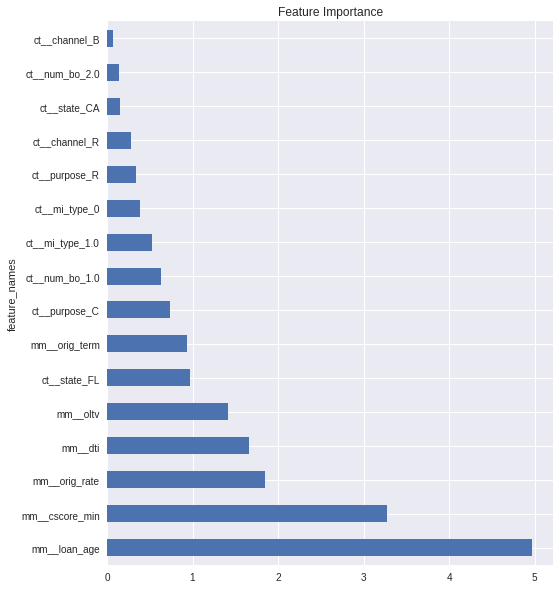

In [ ]:
plt.figure(figsize=(8,10))

result_log['abs_feature_importances'].nlargest(16).plot(x='feature_names', y='feature_importances',  kind='barh',title = 'Feature Importance');

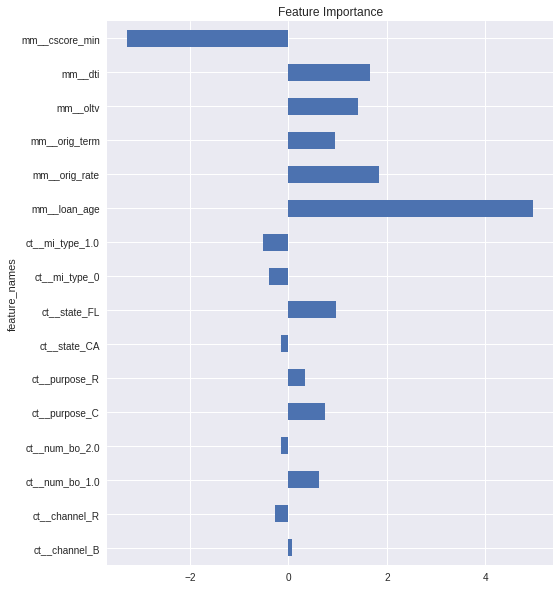

In [ ]:
plt.figure(figsize=(8,10))

result_log["feature_importances"].plot(x=result_log.index, y='feature_importances',  kind='barh',title = 'Feature Importance');

### Confusion Matrix and Classification Report

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, precision_recall_fscore_support, classification_report

In [ ]:
# print('Training score:', log_reg_dummy.score(df_dummy_train, y_train),'Test Score:', log_reg_dummy.score(df_dummy_test, y_test))

In [ ]:
y_pred= pipeline_log.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred)

array([[38602,  1763],
       [15106,  5764]])

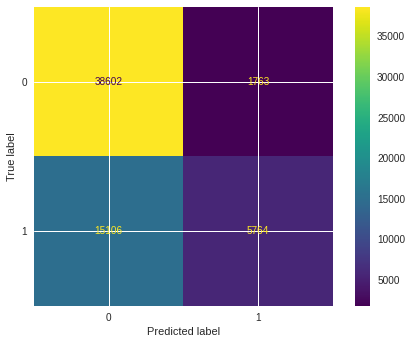

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(pipeline_log, X_test, y_test)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.96      0.82     40365
           1       0.77      0.28      0.41     20870

    accuracy                           0.72     61235
   macro avg       0.74      0.62      0.61     61235
weighted avg       0.73      0.72      0.68     61235



### AUC-ROC Curve

In [ ]:
pred_prob1 = pipeline_log.predict_proba(X_test)

In [ ]:
from sklearn.metrics import roc_curve

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1])

In [ ]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

In [ ]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])

print(auc_score1)

0.8155968723586065


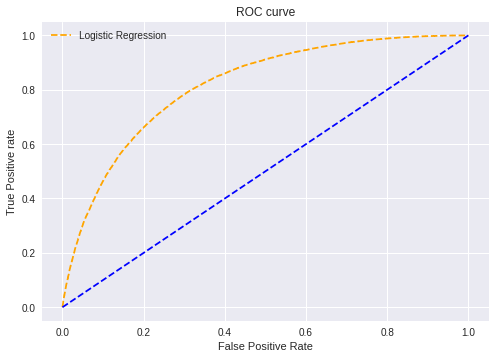

In [ ]:

import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC')
plt.show();

* 1-specificity=fpr
* sensitivity= tpr


https://www.geeksforgeeks.org/auc-roc-curve/


> Our base case is:
>   - First Flag: No
>   - Homeready Program Indicator: No
>   - Oltv mean is 72%
>   - Orig Term median is 360 months.
>   - Orig_rate median is 5.5%
>   - Loan age median is 41 months.
>   - Credit score min mean is 724.
>   - DTI mean is 35%
>   - mi_pct median is 25%.

> Under these assumptions:
>   - If the borrower is a first time home buyer, the probability of default increases by
>   - relocation_mortgage_indicator
>   - high_balance_loan_indicator
>   - channel
>   - num_bo
>   - purpose
>   - prop
>   - no_units
>   - occ_stat
>   - state
>   - mi_type



2. Why are the coefficients of statistical models and our logistic regression function different?
3. We need to check the confusion matrix to check the reliability of our models based on our test set.
4. Why the shapes of df_dummy and df_dummy_test is different?




### Model Analysis Using Statistical Models

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
formula = '+'.join(X_train.columns)

In [ ]:
formula = "Default~"+formula

In [ ]:
formula

In [ ]:
comb_train = X_train

In [ ]:
comb_train['Default']=y_train

In [ ]:
log_reg = smf.logit(formula, data=comb_train).fit()

In [ ]:
print(log_reg.summary())

## **XGBoost Model**

### Grid Search for Xgbooost


In [ ]:
model4 = XGBClassifier()
pipeline4 = Pipeline(steps=[('preprocessor', transformer2),('selector', SelectKBest(chi2, k=16)), ('classifier', model4)])
param_grid = [
    {'classifier__n_estimators' : [10,20,30],
     'classifier__learning_rate' : [0.05,0.1,0.15],
     'classifier__max_depth' : [8,12,16],
     'classifier__min_child_weight' : [2,20],
     'classifier__gamma' : [0.05,0.5]
}]

In [ ]:
from sklearn.model_selection import KFold
cv_method = KFold(n_splits=4, shuffle=True)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
xgb_grid = GridSearchCV(estimator=pipeline4, param_grid=param_grid, cv=cv_method)

In [ ]:
xgb_grid.fit(X_train, y_train)

#print('Training Score:', xgb_grid.score(X_train, y_train))
#print('Testing Score:', xgb_grid.score(X_test, y_test))



GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ct',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['channel',
                                                                          'num_bo',
                                                                          'first_flag',
                                                                          'purpose',
                                                                          'prop',
                                                                          'no_units',
                                                                          'occ_stat',
                                                                          'state',
     

In [ ]:
xgb_grid.best_params_

{'classifier__learning_rate': 0.15,
 'classifier__max_depth': 8,
 'classifier__n_estimators': 30}

In [ ]:
y_pred = xgb_grid.predict(X_test)
print(xgb_grid.best_score_)
print(accuracy_score(y_test, y_pred))

0.8131499722493127
0.7129746060259655


Running the model with best Parameters:



In [ ]:
from xgboost import XGBClassifier
model2 = XGBClassifier(n_estimators=30, learning_rate=0.15, max_depth=8, alpha=0.01,min_child_weight=3,n_jobs=-1)
pipeline_xgb1 = Pipeline(steps=[('preprocessor', transformer2),('selector', SelectKBest(chi2, k=14)), ('classifier', model2)])
pipeline_xgb1.fit(X_train,y_train)
print('Training Score:', pipeline_xgb1.score(X_train, y_train))
print('Testing Score:', pipeline_xgb1.score(X_test, y_test))

Training Score: 0.8210552524754016
Testing Score: 0.7120927574099779


### Feature Importances for XGBoost

In [ ]:
a3 = pipeline_xgb1[:-1].get_feature_names_out()
df_xgb_results = pd.DataFrame(a3)

In [ ]:
pipeline_xgb1.steps[1][1]

SelectKBest(k=14, score_func=<function chi2 at 0x7f8110bb3160>)

In [ ]:
a4 = pipeline_xgb1.steps[2][1].feature_importances_
df_xgb_results2 = pd.DataFrame(a4)

In [ ]:
result_xgb = pd.concat([df_xgb_results, df_xgb_results2], axis = 1)


In [ ]:
result_xgb.columns=['feature_names','feature_importances']

In [ ]:
result_xgb.set_index('feature_names', inplace=True)


In [ ]:
result_xgb.sort_values('feature_importances', ascending=False)

,feature_importances
feature_names,
mm__cscore_min,0.233696
mm__loan_age,0.179096
mm__orig_rate,0.112286
ct__num_bo_1.0,0.096116
mm__orig_term,0.088460
ct__num_bo_2.0,0.069410
ct__state_FL,0.047905
mm__dti,0.035452
ct__purpose_C,0.034886


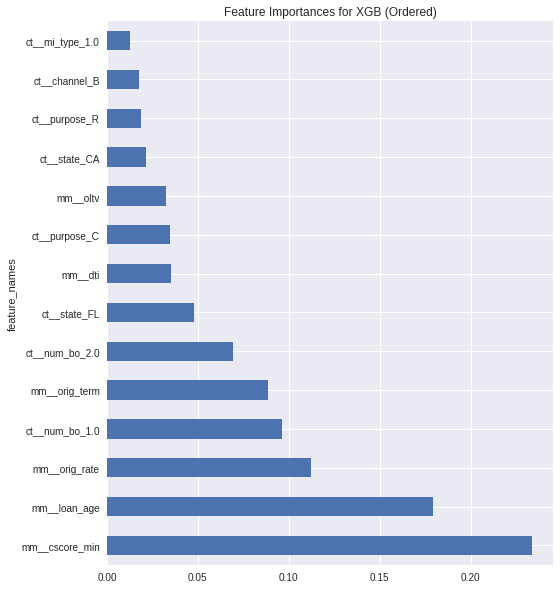

In [ ]:
plt.figure(figsize=(8,10))

result_xgb['feature_importances'].nlargest(16).plot(x='feature_names', y='feature_importances',  kind='barh',title = 'Feature Importances for XGB (Ordered)');

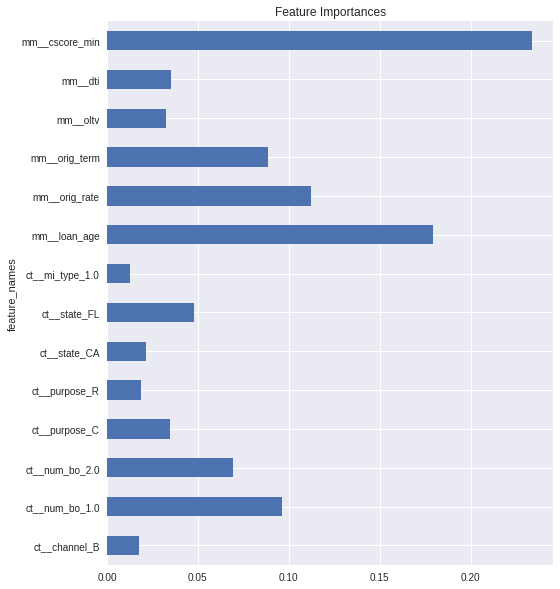

In [ ]:
plt.figure(figsize=(8,10))

result_xgb["feature_importances"].plot(x=result_xgb.index, y='feature_importances',  kind='barh',title = 'Feature Importances');

### Confusion Matrix and Classification Report

In [ ]:
y_pred_xgb1= pipeline_xgb1.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred_xgb1)

array([[39148,  1217],
       [16413,  4457]])

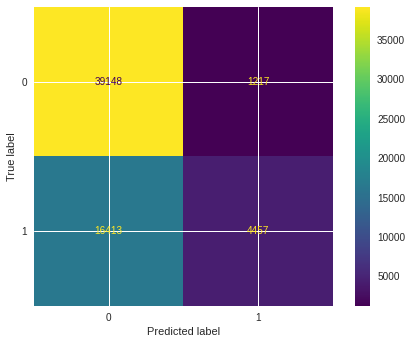

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(pipeline_xgb1, X_test, y_test)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_xgb1))

              precision    recall  f1-score   support

           0       0.70      0.97      0.82     40365
           1       0.79      0.21      0.34     20870

    accuracy                           0.71     61235
   macro avg       0.75      0.59      0.58     61235
weighted avg       0.73      0.71      0.65     61235



# Conclusion and Interpretation of the Results

In [ ]:
df_ins_4plot  = result_log['feature_importances']

In [ ]:
df_ins_4plot

feature_names
ct__channel_B      0.055950
ct__channel_R     -0.270457
ct__num_bo_1.0     0.611210
ct__num_bo_2.0    -0.193810
ct__purpose_C      0.864099
ct__purpose_R      0.359423
ct__state_FL       1.021883
ct__mi_type_0     -0.446348
ct__mi_type_1.0   -0.506907
mm__loan_age       4.204949
mm__orig_rate      1.700655
mm__orig_term      0.880962
mm__oltv          -0.419267
mm__ocltv          2.427976
mm__dti            1.591532
mm__cscore_min    -3.280810
Name: feature_importances, dtype: float64

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
fig = plt.figure(figsize=(10,8))
fig.suptitle('Default: Marginal Plot for {}.'.format(x_var_plot), fontsize=16)
gs = gridspec.GridSpec(2, 2, hspace=.1, height_ratios=[2, 1])

# the first subplot for model performance along the feature of interest in-sample
ax0 = plt.subplot(gs[0])
s=df_ins_4plot.groupby([pd.cut(df_ins_4plot[x_test],bins=bin_size)]).mean() [y_test]
line0, = ax0.plot(s.index.astype(str), s.values, color='r',label='line1')
sp=df_ins_4plot.groupby([pd.cut(df_ins_4plot[x_test],bins=bin_size)]).mean() [y_pred]
line1, = ax0.plot(sp.index.astype(str), sp.values, color='g',label='line2')
plt.title('Build')

# the second subplot for counts for that feature in-sample
# shared axis X
ax1 = plt.subplot(gs[2], sharex = ax0)
ax0.grid()
ax1.grid()

t=df_ins_4plot.groupby([pd.cut(df_ins_4plot[x_var],bins=bin_size)]).count() [x_var]
plt.setp(ax0.get_xticklabels(), visible=False)
line2= ax1.bar(t.index.astype(str), t.values, color='b')
plt.xticks(rotation = 90)
# remove last tick label for the second subplot
yticks = ax1.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
# put legend on first subplot
ax0.legend((line0, line1), ('Actuals', 'Predictions'), loc='lower left')

# the third subplot for model performance along the feature of interest in holdout
ax2 = plt.subplot(gs[1])

# log scale for axis Y of the first subplot
s=df_oot_4plot.groupby([pd.cut(df_oot_4plot[x_var],bins=bin_size)]).mean() [y_var]
line4, = ax2.plot(s.index.astype(str), s.values, color='r',label='line1')
sp=df_oot_4plot.groupby([pd.cut(df_oot_4plot[x_var],bins=bin_size)]).mean() [y_pred]
line5, = ax2.plot(sp.index.astype(str), sp.values, color='g',label='line2')
plt.title("Post-Build")


# the fourth subplot for counts for that feature in holdout
# shared axis X
ax3 = plt.subplot(gs[3], sharex = ax2)
ax2.grid()
ax3.grid()
t=df_oot_4plot.groupby([pd.cut(df_oot_4plot[x_var],bins=bin_size)]).count() [x_var]
plt.setp(ax2.get_xticklabels(), visible=False)
line6= ax3.bar(t.index.astype(str), t.values, color='b')
plt.xticks(rotation = 90)
# remove last tick label for the second subplot
yticks = ax3.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.show()

***Interpretation:***
These interpretation were based on feature importance data that were derived from Logistic Regression and XGBoost Models.


*   Credit score seems to have a major impact in determining the default cases. If a borrower has a high credit score, it implies a lower proobability of default.
*   As loan age increases and time passes, the default probability increases proportionally. So, it might be in the best interest of the lenders to review the health of the borrowers by regularly reviewing the outstanding loans.
*   Both models imply origination rate has an important role in determining client's default probability. If the origination rate is higher which was determined as a result various factors, then client may have a higher probaility of default.
*   Both models suggest that if there are more than one borrower, there is less likelyhood of default. This is intuitive in a way as there may be more borrowers, there are more income or sources to support mortgage payments.
*   Loan to Value ratio seems to show a positive correlation with the default rates. It is also somehow intuitive since if a borrower has the ability to pay more downpayment, it is fair to  say that there is surplus income to support mortgage payments.
*   The longer the orig term, the higher is the default probability. Those borrowers who take shorter term loans are less likely to default as they were able to support higher mortgage payments in a shorter time frame.
*   Both models suggest that if the borrower resides in Florida, there is a higher chance of default. Mortgage application from Florida may require more in-depth evaluation which may look at the factors mentioned above in more detail.
*   Both model suggest that the channel that mortgage application comes from provides more insight regarding mortgage default. If the mortgages come through retail channel, there is a higher chance of default.
*   According to the logistic regression model, if the purpose of the property is rental, then there is a higher probability of default. Based on XGBoost model, correspondent channel implies a higher chance of default.
*   If the debt-to-income ratio is high, then the default probability is higher.









